# 05_lmu_dms_tuning


In [ ]:
#default_exp tune.lmu_dms

In [ ]:
#@title Environment Setup
try:
    # See if we are running on google.colab
    from google.colab import files
    IN_COLAB = True
    !pip install --upgrade nengo nengo-gui nbdev git+https://github.com/neuromorphs/grill-srnn-pfc.git
    !jupyter serverextension enable nengo_gui.jupyter
    # TODO: kaggle creds for downloading data 
    
except ModuleNotFoundError:
    IN_COLAB = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
import argparse
import logging
from sklearn import metrics
import numpy as np
import nengo
import nengo.utils.least_squares_solvers as lss
import nni
from srnn_pfc.lmu import make_lmu_dms  # LDN, make_ldn_B_A,


logger = logging.getLogger('lmu_dms_tuning')



In [ ]:
#export
def generate_default_params():
    return {"theta": 6.0, "q": 6, "n_neurons": 1000, "tau": 0.1}


In [ ]:
import srnn_pfc.tune
import os
import json
import yaml


exp_path = os.path.dirname(srnn_pfc.tune.__file__)
search_space = {
  "theta": {"_type": "quniform", "_value": [6.0, 6.0, 1.0]},
  "q": {"_type": "quniform", "_value": [6, 6, 1]},
  "n_neurons": {"_type": "choice", "_value": [5, 10, 25, 50, 100, 150, 200, 250, 500, 1000, 2000]},
  "tau": {"_type": "quniform", "_value": [0.05, 0.6, 0.1]}
}

with open(os.path.join(exp_path, 'search_space.json'), 'w') as fp:
    json.dump(search_space, fp, indent=2)


In [ ]:
config = {
    "authorName": "default",
    "experimentName": "lmu_dms",
    "trialConcurrency": 2,
    "maxExecDuration": "10h",
    "maxTrialNum": 100,
    "trainingServicePlatform": "local",
    "searchSpacePath": "search_space.json",
    "useAnnotation": False,
    # "logDir": LOG_DIR,
    "logLevel": "debug",
    "tuner": {
        "builtinTunerName": "TPE",
        "classArgs": {
            "optimize_mode": "maximize"
        }
    },
    # "assessor": {
    #     "builtinAssessorName": "Medianstop",
    #     "classArgs": {
    #         "optimize_mode": "maximize"
    #     }
    # }
    # The path and the running command of trial
    "trial":  {
      "command": "python -m srnn_pfc.tune.lmu_dms",
      "codeDir": ".",
      "gpuNum": 0
    }
}

with open(os.path.join(exp_path, "lmu_dms_nni_cfg.yml"), "w") as fp:
    fp.write(yaml.dump(config, default_flow_style=False))

In [ ]:
#export
def run_trial(params,
              ens_seed=1337,
              train_trials_seed=1337,
              test_trials_seed=1234,
              train_trials_per_cond=5,
              test_trials_per_cond=5):
    # Create model for training
    srate = 1000
    for key in ['q', 'n_neurons']:
        params[key] = int(params[key])
    train_model, train_probes = make_lmu_dms(
                                    theta=params['theta'],
                                    q=params['q'],
                                    n_neurons=params['n_neurons'],
                                    seed=ens_seed,
                                    out_transform=None,
                                    n_trials_per_cond=train_trials_per_cond,
                                    trial_seed=train_trials_seed,
                                    tau=params['tau'])
    # Generate training data
    train_sim = nengo.Simulator(train_model)
    n_train_trials = train_trials_per_cond * 8 * 2  # 16 conditions
    train_sim.run(6 * n_train_trials)  # 6 seconds per trial
    train_sim.close()

    # Solve for weights - Data are generally too large for nengo's filt so we slice
    #  them to only evaluate specific ranges.
    eval_ranges = [(0, 0.25), (0.75, 1.75), (2.75, 3.75), (4.75, 6.0)]
    trial_tvec = np.arange(0, 6.0, 1/srate)
    b_eval = np.zeros(trial_tvec.shape, dtype=bool)
    for t_win in eval_ranges:
        b_eval = np.logical_or(b_eval, np.logical_and(t_win[0] <= trial_tvec,
                                                      trial_tvec < t_win[1]))
    b_eval = np.tile(b_eval, n_train_trials)

    filt = nengo.synapses.Lowpass(0.01)
    Y = filt.filt(train_sim.data[train_probes['ideal']][b_eval])
    A = filt.filt(train_sim.data[train_probes['ensemble']][b_eval])

    D, info = nengo.solvers.LstsqL2(solver=lss.LSMRScipy())(A, Y)
    Y = A = None

    # Create a new model with the learned weights
    test_model, test_probes = make_lmu_dms(
                                  theta=params['theta'],
                                  q=params['q'],
                                  n_neurons=params['n_neurons'],
                                  seed=ens_seed,
                                  out_transform=D.T,
                                  n_trials_per_cond=test_trials_per_cond,
                                  trial_seed=test_trials_seed,
                                  tau=params['tau'])

    # Run test simulation - break after N trials to report cumulative accuracy
    def get_labels_from_sim(sim, n_trials):
        samps = 6 * srate * n_trials
        Y = sim.data[test_probes['ideal']][-samps:]
        A = sim.data[test_probes['output']][-samps:]
        b_slice = Y != 0
        label = Y[b_slice].reshape(n_trials, -1)[:, 0]
        score = np.mean(A[b_slice].reshape(n_trials, -1), axis=-1)
        return label, score

    total_test_trials = test_trials_per_cond * 8 * 2
    test_sim = nengo.Simulator(test_model)

    test_ix = min(20, total_test_trials)
    test_sim.run(6 * test_ix)
    labels, scores = get_labels_from_sim(test_sim, test_ix)

    trial_step = 10
    while test_ix < total_test_trials:
        test_sim.run(6 * min(trial_step, total_test_trials - test_ix))
        label, score = get_labels_from_sim(test_sim, trial_step)
        labels = np.append(labels, label)
        scores = np.append(scores, score)
        fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
        test_auc = metrics.auc(fpr, tpr)
        nni.report_intermediate_result(test_auc)
        test_ix += trial_step

    test_sim.close()
    logger.debug('test_sim.close() returned.')
    logger.debug('Final result is: %d', test_auc)
    nni.report_final_result(test_auc)
    logger.debug('Sent final result. Trial complete.')


In [ ]:
#export
try:
    from nbdev.imports import IN_NOTEBOOK
except ModuleNotFoundError:
    IN_NOTEBOOK = False

    
if __name__ == "__main__" and not IN_NOTEBOOK:
    parser = argparse.ArgumentParser()
    parser.add_argument("--ens_seed", type=int, default=1337,
                        help="seed for random initialization of ensemble", required=False)
    parser.add_argument("--train_trials_seed", type=int, default=1337,
                        help="seed for random initialization of training trial conditions", required=False)
    parser.add_argument("--test_trials_seed", type=int, default=1234,
                        help="seed for random initialization of test trial conditions", required=False)
    parser.add_argument("--train_trials_per_cond", type=int, default=5,
                        help="training trials per task condition", required=False)
    parser.add_argument("--test_trials_per_cond", type=int, default=5,
                        help="testing trials per task condition", required=False)
    args, unknown = parser.parse_known_args()
    
    try:
        params = {**generate_default_params(), **nni.get_next_parameter()}
        logger.debug(params)
        run_trial(params,
                  ens_seed=args.ens_seed,
                  train_trials_seed=args.train_trials_seed,
                  test_trials_seed=args.test_trials_seed,
                  train_trials_per_cond=args.train_trials_per_cond,
                  test_trials_per_cond=args.test_trials_per_cond
                 )
    except Exception as e:
        logger.exception(e)
        raise


In [ ]:
params = generate_default_params()
run_trial(params)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[08/27/2020, 05:50:20 PM] INFO (nni) Intermediate result: 1.0  (Index 0)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[08/27/2020, 05:50:55 PM] INFO (nni) Intermediate result: 1.0  (Index 1)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[08/27/2020, 05:51:32 PM] INFO (nni) Intermediate result: 1.0  (Index 2)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[08/27/2020, 05:52:09 PM] INFO (nni) Intermediate result: 1.0  (Index 3)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[08/27/2020, 05:52:47 PM] INFO (nni) Intermediate result: 1.0  (Index 4)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[08/27/2020, 05:53:25 PM] INFO (nni) Intermediate result: 0.99625  (Index 5)
[08/27/2020, 05:53:25 PM] INFO (nni) Final result: 0.99625


Now close this notebook to free up RAM and run `nnictl create --config grill-srnn-pfc\srnn_pfc\tune\lmu_dms_nni_cfg.yml`

When that's done, but with the session still open, run the following cell to import the results.

In [ ]:
import ast
import json
import requests
import numpy as np


NNI_REST_ENDPOINT = "http://localhost:8080/api/v1/nni"
NNI_STATUS_URL = NNI_REST_ENDPOINT + "/check-status"
NNI_TRIAL_JOBS_URL = NNI_REST_ENDPOINT + "/trial-jobs"
all_trials = requests.get(NNI_TRIAL_JOBS_URL).json()
trials = [
    (
        ast.literal_eval(ast.literal_eval(trial["finalMetricData"][0]["data"])),
        trial["logPath"].split(":")[-1],
        json.loads(trial["hyperParameters"][0])["parameters"]
    )
    for trial in all_trials
]
res = np.array([_[0] for _ in trials])
hps = list(trials[0][2].keys())
dat = np.zeros((len(trials), len(hps)))
for t_ix, t in enumerate(trials):
    for c_ix, hp in enumerate(hps):
        dat[t_ix, c_ix] = t[2][hp]

In [ ]:
# Save for later

import os
import srnn_pfc.tune


exp_path = os.path.dirname(srnn_pfc.tune.__file__)

np.savez(os.path.join(exp_path, 'result2.npz'), res=res, hps=hps, dat=dat)

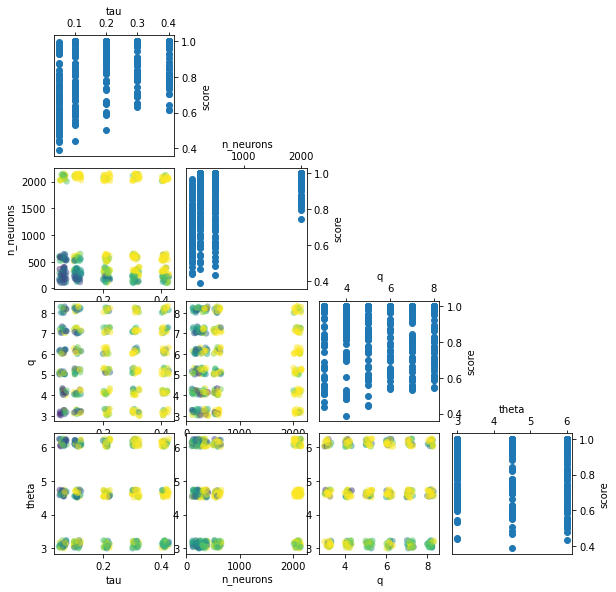

In [ ]:
# Load and plot

import matplotlib.pyplot as plt


res_file = np.load(os.path.join(exp_path, 'result2.npz'))
res = res_file['res']
hps = res_file['hps']
dat = res_file['dat']
jit_dat = dat + np.random.randn(*dat.shape) * 0.08 * np.std(dat, axis=0)


n_dims = len(hps)
fig, ax = plt.subplots(n_dims, n_dims, figsize=(2 * n_dims, 2 * n_dims))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
                    hspace=0.1, wspace=0.1)

for i, ki in enumerate(hps):
    for j, kj in enumerate(hps):
        if i == j:
            ax[i, i].scatter(dat[:, i], res)
            ax[i, i].yaxis.tick_right()
            ax[i, i].yaxis.set_label_position('right')
            ax[i, i].set_ylabel('score')
            ax[i, i].xaxis.tick_top()
            ax[i, i].xaxis.set_label_position('top')
            ax[i, i].set_xlabel(ki)
        elif i > j:
            ax[i, j].scatter(jit_dat[:, j], jit_dat[:, i],
                             c=res, s=40, lw=0., cmap='viridis',
                             alpha=0.5)
            if i == len(hps) - 1:
                ax[i, j].set_xlabel(kj)
            if j == 0:
                ax[i, j].set_ylabel(ki)
        elif j > i:
            ax[i, j].axis("off")